In [31]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from collections import defaultdict
from urllib import request
import os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dropout,Dense
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import shutil
import random
import glob
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
tf.random.set_seed(42)
from collections import deque

In [21]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [22]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "F:/Equal",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3779 files belonging to 8 classes.


In [23]:
class_names = dataset.class_names
class_names

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

In [24]:
file_path= "F:/Equal"

In [25]:
!pip install split_folders

In [26]:
import splitfolders
splitted_folder= "F:/Equal"
def train_test(train_size=0.8,test_size=0.2,images_folder=file_path,splitted_folder=splitted_folder):
  train_size = train_size
  test_size = test_size
  input_folder = images_folder
  output_folder = splitted_folder
  splitfolders.ratio(input_folder,output_folder, seed = 1337, ratio = (train_size,test_size), group_prefix = None)
train_test()

Copying files: 0 files [00:00, ? files/s]

Copying files: 3779 files [02:26, 25.77 files/s]


In [27]:
train_dir ="F:/Equal/train"  
test_dir = "F:/Equal/val"

In [30]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
    input_shape=(224, 224, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name ="data_augmentation")

In [32]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=42
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = test_data.class_names
val_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3022 files belonging to 8 classes.
Found 757 files belonging to 8 classes.


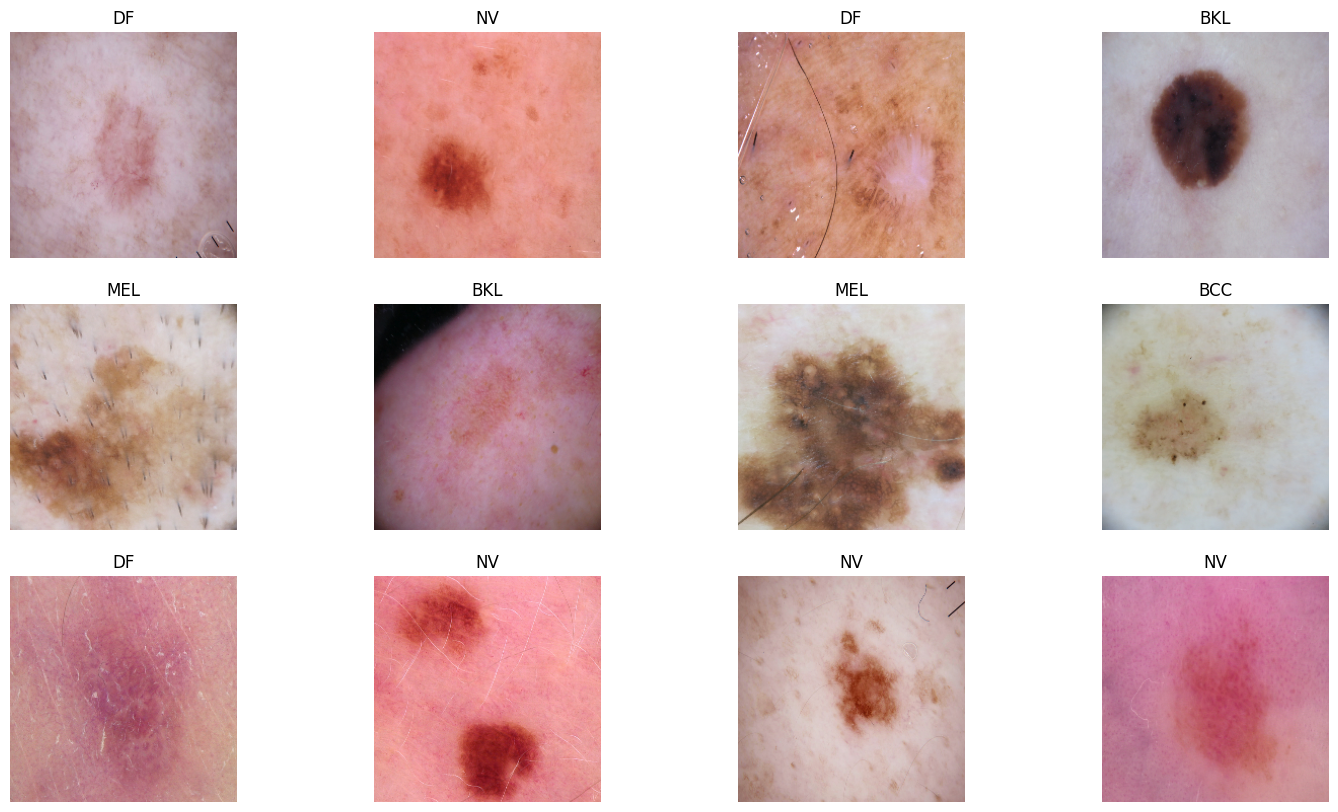

In [33]:
plt.figure(figsize=(18,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

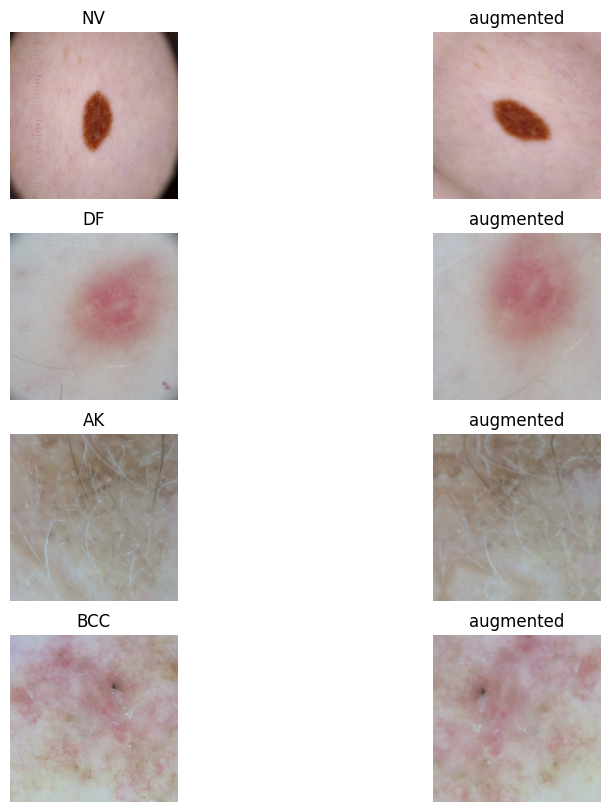

In [34]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        plt.imshow(augmented_image_batch[i])
        plt.title(f"augmented")
        plt.axis("off")

In [35]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

In [36]:
from tensorflow.keras.models import Model

In [37]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [38]:
x = mobile.layers[-6].output

In [39]:
hidden=tf.keras.layers.GlobalAveragePooling2D()(x)

In [40]:
output = Dense(units=8, activation='softmax')(hidden)

In [41]:
model =Model(inputs=mobile.input, outputs=output)

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [43]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [44]:
history = model.fit(
    train_data,
    epochs=20,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)

Epoch 1/20
95/95 [==============================] - 716s 7s/step - loss: 1.2094 - accuracy: 0.6165 - val_loss: 4.5644 - val_accuracy: 0.4769
Epoch 2/20
95/95 [==============================] - 526s 6s/step - loss: 0.5175 - accuracy: 0.8210 - val_loss: 2.4128 - val_accuracy: 0.5020
Epoch 3/20
95/95 [==============================] - 434s 5s/step - loss: 0.2817 - accuracy: 0.8987 - val_loss: 1.1625 - val_accuracy: 0.6816
Epoch 4/20
95/95 [==============================] - 529s 6s/step - loss: 0.1593 - accuracy: 0.9424 - val_loss: 1.6027 - val_accuracy: 0.6129
Epoch 5/20
95/95 [==============================] - 491s 5s/step - loss: 0.1796 - accuracy: 0.9381 - val_loss: 1.7743 - val_accuracy: 0.5760
Epoch 6/20
95/95 [==============================] - 521s 5s/step - loss: 0.1801 - accuracy: 0.9358 - val_loss: 1.3354 - val_accuracy: 0.6711
Epoch 7/20
95/95 [==============================] - 440s 5s/step - loss: 0.1732 - accuracy: 0.9424 - val_loss: 2.0770 - val_accuracy: 0.5733
Epoch 8/20
95

In [45]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

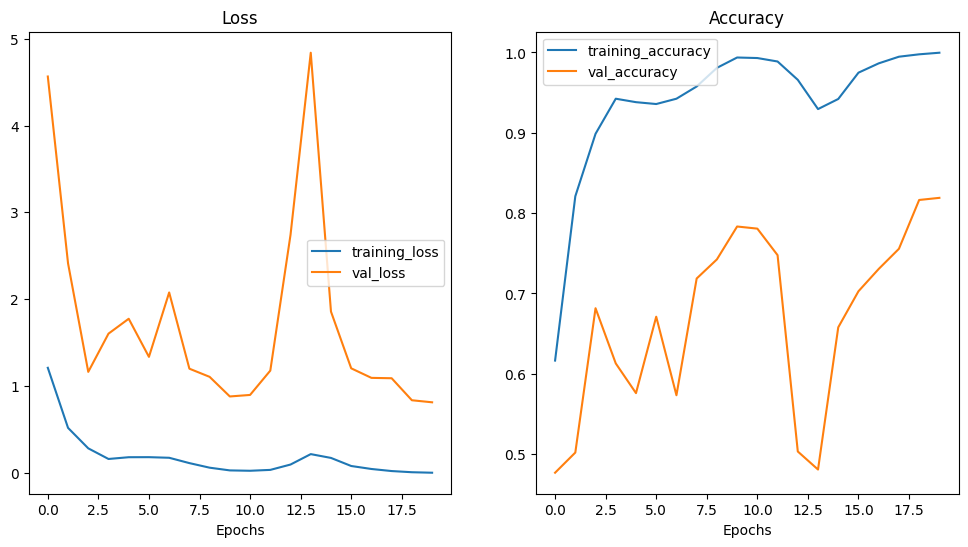

In [46]:
plot_loss_curves(history)

In [47]:
model.evaluate(test_data)

24/24 [==============================] - 32s 1s/step - loss: 0.8120 - accuracy: 0.8190


[0.8120409250259399, 0.8190224766731262]

1/1 [==============================] - 17s 17s/step


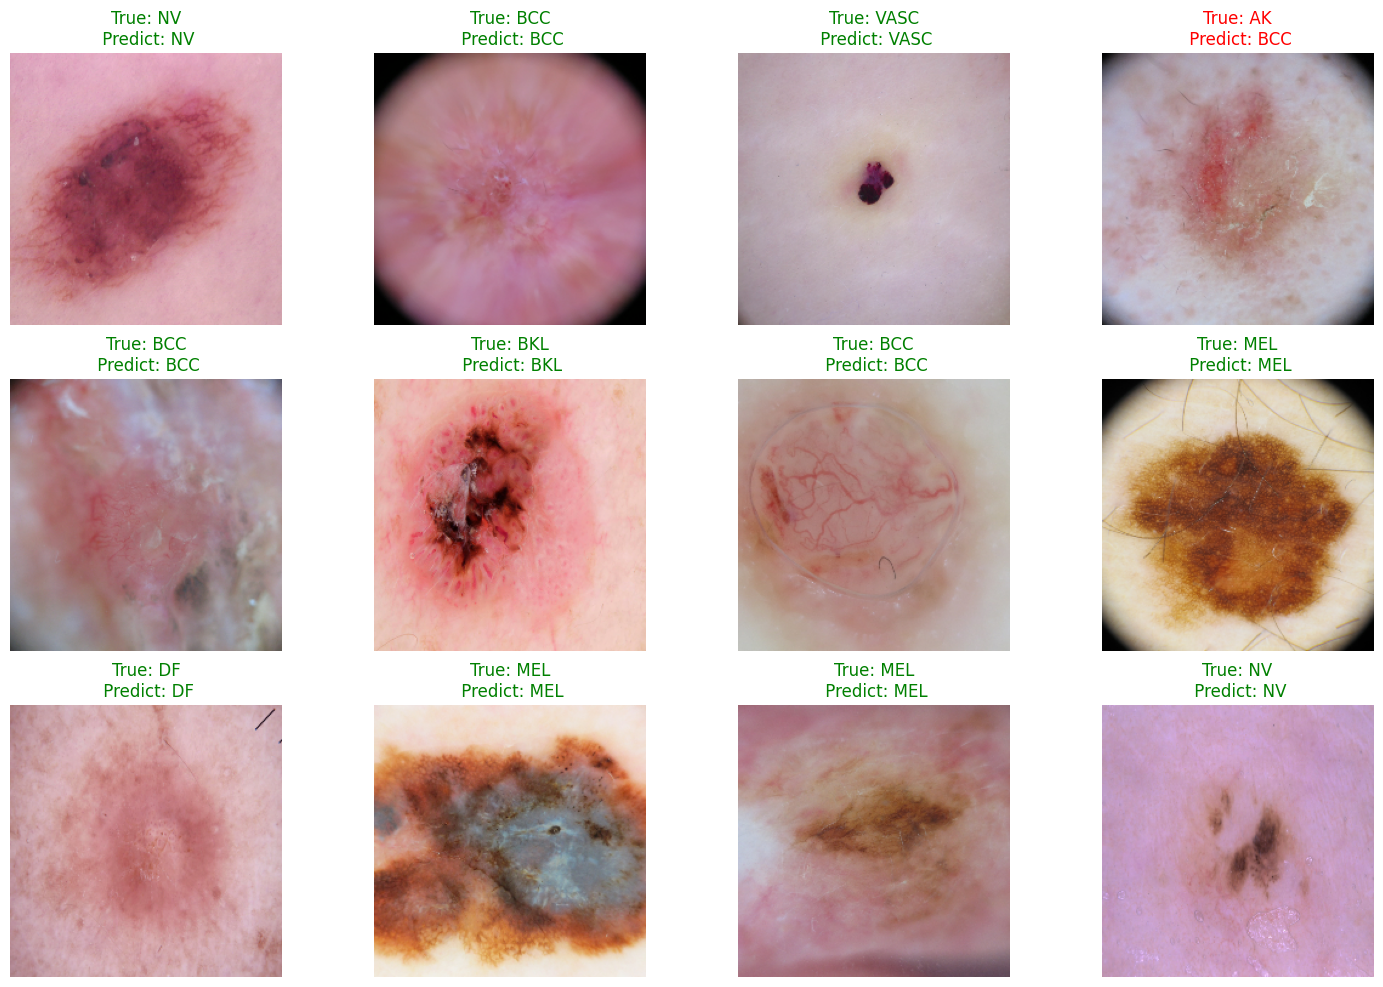

In [48]:
plt.figure(figsize=(18,12))
for image_batch,label_batch in test_data.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

In [49]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels,
         )
  
  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)


In [50]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 2s 2s/step


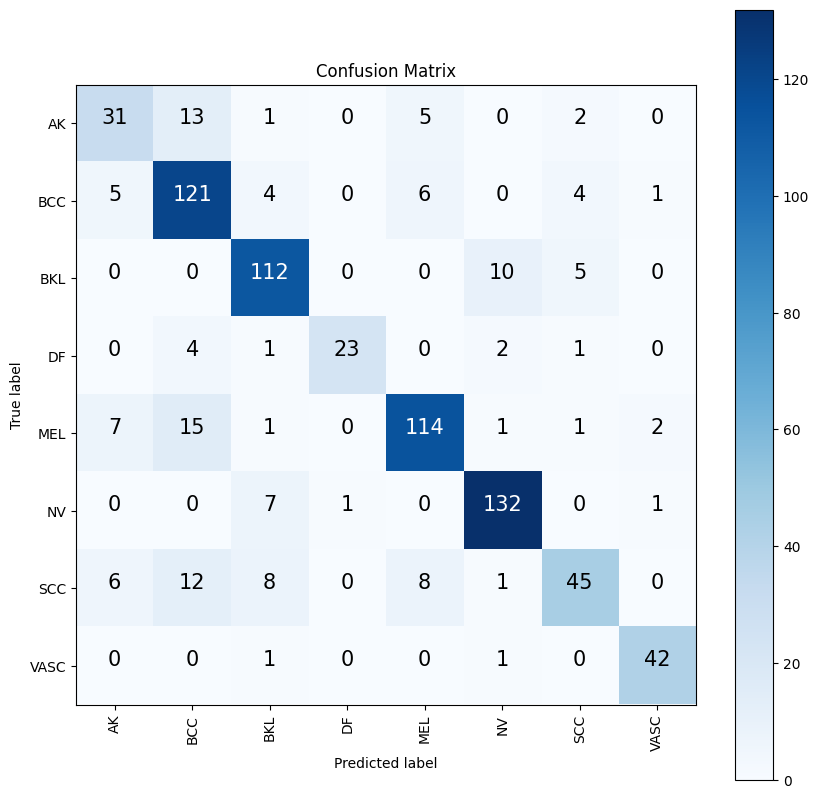

In [51]:
make_confusion_matrix(y_true, y_pred, class_names)

In [52]:
from sklearn.metrics import precision_score, accuracy_score, recall_score
print("Test Accuracy : {:.2f} %".format(accuracy_score(y_true,y_pred)*100))
print("Precision score : {:.2f}%".format(precision_score(y_true,y_pred,average='micro')*100))
print("Recall score : {:.2f}%".format(recall_score(y_true,y_pred,average='micro')*100))


Test Accuracy : 81.90 %
Precision score : 81.90%
Recall score : 81.90%
